# Parallel Computing for Economics with Python

## Types of Parallel Computing

When boiled down to its basics there are two types of parallel computing environments: Shared Memory Multiple Processors (SMMP) and Distributed Memory Multiple Processors.  SMMP will be the parallel environment most people are familiar with.  Nearly all computers today have two or more processors sharing the same memory.  Languages like C,C++ and Fortran can use OpenMP to quickly parallelize for loops in and SMMP environment.  In addition many numpy operations such as `.dot` are compiled to take advantage of parallel code in the BLAS matrix libraries.  Shared memory environments are generally easier to write parallel code for: in many cases it can be as simple as adding `#parfor` to a for loop.  There is a limit, however to the number of processors that can share the same memory and eventually we have to move on to a distributed memory environment.

In a DMMP environment each computational node has its own memory and the nodes are linked together through a network.  As the memory for the nodes are separate, they need to communicate periodically to work on a joint project.  There are multiple ways to handle this communication, for this lecture we will focus on two: MPI which can be accessed through the python library `mpi4py` and IPython parallel.  At the heart of the python language is the GIL, or Global Interpreter Lock, this allows only one thread to access the memory of the python program at a point in time.  This effectively requires python code to be parallelized using DMMP techniques.  This may seem like a disadvantage, but in reality most economic applications are so easily parallelized that the overhead of using MPI is negligible.

## mpi4py

We will begin with an overview of how to use mpi4py to produce parallel code.  MPI itself has a rich set of commands to govern the communications between processes.  We will be focussing on a simple subset of these, but they should be sufficient for almost all economic applications.  The best way to think about parallel code using mpi4py in this setup is $N$ processes running the same python script independently of each other which occasionally communicate with each other via commands from mpi4py.

When they communicate it is necessary for the processes to distinguish one from another.  Thus, each is assigned its own rank.  If an MPI command launches 8 processes then the ranks of these processes will run from 0 to 7.  This will allow us to have the script execute different commands for each process.  To illustrate this let's consider the following simple program:

In [4]:
from mpi4py import MPI

comm = MPI.COMM_WORLD #retrieve the communicator module
rank = comm.Get_rank() #get the rank of the process
size = comm.Get_size() #get the number of processes

print("Hello world from process "+str(rank)+" of " + str(size))

Hello world from process 0 of 1


In this case the code was launched from a single application so the number of processes was one.  To launch more than one process running the same python script we need to launch them using the command `mpiexec`.  For example, if the code above was stored in `mpi_helloworld` to launch 8 processes we would run the following command in the terminal. (All code files used in this tutorial can be produced by jumping to the [.py files appendix](#Appendix:-.py-files-used) and running all its cells)

In [7]:
!mpiexec -n 8 python ./mpi/mpi_helloworld.py 

Hello world from process 2 of 8
Hello world from process 7 of 8
Hello world from process 5 of 8
Hello world from process 3 of 8
Hello world from process 4 of 8
Hello world from process 1 of 8
Hello world from process 0 of 8
Hello world from process 6 of 8


Note the ! is only necessary to launch the shell command using IPython.

## The `mpi4pi` Toolkit

Handling communication between processes is the most important part of parallel programming. There are a multitude of commands in mpi4py to do this but we will focus on 3: `gather`, `allgather` and `bcast`.  These will allow us to confront almost all of the problems we face in Economics.

### `gather` and `allgather`

We use `gather` if there is data on all processes which we want to pull together into a single process.  For example, if you have a program that solves an optimization problem using value function iteration, each process can solve the optimization problem on a separate chunk of the state space.  It would then be possible to gather the results for interpolation before continuing on to the next stage of the iteration.  For the process of rank 0 `gather` returns a list with the data from each process ordered by the rank of the process.  For the rest of the processes `gather` returns a `None`.

Another natural application of gather is Monte Carlo integration.  In this simple example we compute the expected value random variable `cos(x)` when x is distributed according to a standard normal distribution. The code is in `MPI_montecarlo.py`.

In [9]:
import numpy as np
from mpi4py import MPI

N = 10000

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

x = np.random.randn(N)
my_result = np.cos(x).mean() #my average

#now average accross all processes
results = comm.gather(my_result)
if rank == 0: #only rank =0 process has the results
    print(np.mean(results))

0.607712577686


The result above was computed with a single process.  We can run it with multiple processes via `mpiexec`.

In [11]:
!mpiexec -n 8 python ./mpi/MPI_montecarlo.py

0.608004554172


`allgather` performs a very similar function to gather.  The difference is in which processes receive the data.  In the above example the process with rank 0 has an object `results` which contains a list of the result of the sum for each process.  For every other process `results` is a None.  If `allgather` were used in place of `gather` the results object would be the same in all processes.  Consider the following variant of our Monte Carlo example

In [14]:
import numpy as np
from mpi4py import MPI

N = 10000

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

x = np.random.randn(N)
my_result = np.cos(x).mean() #my average

#now gather from all processes
results = comm.gather(my_result)

print("Gather result for process " + str(rank) +":",results)

#now allgather from all processes
results = comm.allgather(my_result)

print("Allgather results for process " + str(rank) + ":",results)

Gather result for process 0: [0.61149086018736976]
Allgather results for process 0: [0.61149086018736976]


If we run this for multiple processes we get the following results:

In [16]:
!mpiexec -n 4 python ./mpi/MPI_montecarlo_allgather.py

Gather result for process 1: None
Allgather resuts for process 1: [0.60739954433778476, 0.60575648335252663, 0.60036399512263472, 0.60706709866435216]
Gather result for process 2: None
Allgather resuts for process 2: [0.60739954433778476, 0.60575648335252663, 0.60036399512263472, 0.60706709866435216]
Gather result for process 3: None
Allgather resuts for process 3: [0.60739954433778476, 0.60575648335252663, 0.60036399512263472, 0.60706709866435216]
Gather result for process 0: [0.60739954433778476, 0.60575648335252663, 0.60036399512263472, 0.60706709866435216]
Allgather resuts for process 0: [0.60739954433778476, 0.60575648335252663, 0.60036399512263472, 0.60706709866435216]


As expected with gather only the process with rank 0 has the list containing the Monte Carlo average for each process.  With `allgather` each process has the same list.  As all of the processes are running simultaneously the printed results may be jumbled, but the code will always print the `gather` results before the `allgather` results.  The reason for this is that both `allgather` and `gather` are blocking.  Once a process has reached the `gather` command it will not continue until all other processes have reached that command as well.  This ensures that your code will remained synced throughout execution.

There is one caveat.  On some systems I have found `allgather` may hang if there are too many processes.  If this occurs it may be necessary to replace and `allgather` command with a combination of `gather` and the `bcast` command discussed below or the numpy versions of these commands.

## bcast

One can think of `bcast` as the reverse of `gather`.  Instead of gathering data at the root process (the process with rank 0), `bcast` takes data on the root process and sends it to all the other processes.  Take this simple code:

In [17]:
import numpy as np
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

if rank == 0:
    A = np.random.rand(5,5)
else:
    A = None
    
B = comm.bcast(A)

This code creates a `5x5` matrix on the process with rank 0.  It then broadcasts that matrix to all the other processes and stores it in the variable `B`.  Note, that `A` still holds none for the processes with rank other than 0.

### What can be sent?

A natural question at this point is what kind of python objects can be sent between processes with `mpi4py`.  It turns out that nearly all python objects can be sent via `mpi4py`.  The way that an object is sent via mpi4py is that it is first pickled, which converts the python object to a string.  The string is a then sent to the other processes which then convert it back into its original form.  This makes `mpi4py` very flexible.  Nearly all objects in python are picklable, including most user defined classes, which means that most objects can be communicated from one object to another.  In some cases, such as classes defined with Cython, it may be necessary to tell python how to pickle and unpickle an object, but these are generally outside normal usage.

This flexibility does have a drawback.  Python must convert the object to a string and then back again, which can make sending an object slow.  If your program relies on frequent communication between processes it may be worth it to use versions of `gather` and `allgather` designed for numpy arrays.  When these are used Python no longer pickles the object and instead shares the numpy array data directly.  We discuss these in the next section.

### The Numpy Versions

All of the `mpi4py` commands we have discussed have corresponding numpy versions.  You can recognize these commands because they begin with a capital letter.  For example, the numpy version of `allgather` is `Allgather`.  The usage of these commands is also slightly different.  To see how this works let's consider the following example:

In [19]:
import numpy as np
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# create a 2x2 array filled with the rank of the process
x = np.ones((2,2)) * rank 

# create an empty array to store the gathered result
X = np.empty((2*size,2))

#use numpy Allgather
                #send buffer   #recv buffer
comm.Allgather([x, MPI.DOUBLE],[X, MPI.DOUBLE])

if rank ==0:
    print(X)

[[ 0.  0.]
 [ 0.  0.]]


If we run this command with 4 processes it returns:

In [22]:
!mpiexec -n 4 python ./mpi/MPI_Allgather.py

[[ 0.  0.]
 [ 0.  0.]
 [ 1.  1.]
 [ 1.  1.]
 [ 2.  2.]
 [ 2.  2.]
 [ 3.  3.]
 [ 3.  3.]]


We see some immediate differences between the usage of `allgather` and `Allgather`.  The first is that `Allgather` gives us a numpy array rather than a list.  A good rule of thumb is that `Allgather` will return the equivalent of `np.vstack(comm.Allgather(x))`.  We also must preallocate space for that array.  `Allgather` takes two inputs. `[x, MPI.DOUBLE]` is the send buffer where we specify the numpy array we wish to send and the type of data stored in it.  `[X, MPI.DOUBLE]` is the numpy array where we wish to store the result and the type of data it holds.  `Allgather` and `Gather` work best when all of the data spread across the different processes have the same shape otherwise it will also be necessary to the length of each vector as well.

## An Economic Example

We can now use `mpi4py` to solve a simple economics problem in parallel.  For this example we will study a simple consumption savings model with incomplete markets.  Consider an agent how faces a random endowment stream $y_t = exp(z_t)$ which is AR(1) in logs
$$
    z_t = \rho z_{t-1} + \epsilon_t
$$  The agent cannot perfectly insure against this random endowment and can only save through a risk free bond with interest rate $r$.  The budget constraint of the agent is then
$$
    (1+r)a_{t-1} + y_t = c_t + a_t.  
$$  Additionally agents face an ad-hoc borrowing constraint $a_t \geq \underline a$ for all $t\geq0$.

The problem can be written recursively as follows.  Let $V(a,z)$ be the value of an agent who enters the period with assets $a$ and endowment $\exp(z)$.  $V(a,z)$ then solves the following bellman equation
$$
    V(a,z) = \max_{a' \geq \underline a} U( (1+r)a + \exp(z) - a' ) + \beta \mathbb E_z V(a',z')
$$  Define the mapping $T$ associated with the bellman equation as 
$$
    T(V)(a,z) = \max_{a' \geq \underline a} U( (1+r)a + \exp(z) - a' ) + \beta \mathbb E_z V(a',z')
$$the solution to this bellman equation is the fixed point of this mapping.

The python modules `bellman.py`, `primitives.py` and `Main.py` are written to solve this problem, see the [appendix](#Appendix:-.py-files-used) for the code.  `primitives.py` defines the parameters that are the primitives of the problem and may easily be adapted for different types of preferences.  For example we can can create a Para object holding the parameters of our problem as via:

In [23]:
from primitives import primitives_CRRA
Para = primitives_CRRA()

`bellman.py` defines the Bellman Map class.  This can be constructed from a parameter class and an interest rate $r$:

In [24]:
import bellman
r = 0.9995*(1./Para.beta - 1)
T = bellman.BellmanMap(Para,r)

`T` here corresponds exactly to the $T$ defined in the equations above.  For a given continuation value function $V$, `T(V)` is a function that computes the maximum of the agents' utility function.  For example if we define $V_0$ below:

In [26]:
from numpy import *
V0 = lambda a,z : Para.U(exp(z)+r*a)/(1-Para.beta)
print(T(V0)([1.,0.]), T(V0)([1.,1.]))

-19.0776632874 -7.95513729592


It will print out the value after one iteration for an agent with $(a,z) = (1,0)$ and $(1,1)$, respectively.  All of this code is written just as it would be for serial execution and we won't go into detail into the precise nature of the code.  Instead, we will focus on how to parallelize the solution of the Bellman Equation.  The key step is approximating the current value function $T(V)$ via interpolation.  We proceed by creating a grid over the $(a,z)$ space (with more points placed where the value function has greater curvature.

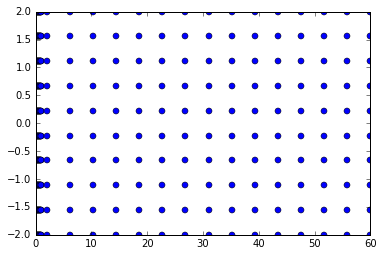

In [27]:
agrid = hstack((linspace(Para.a_min,Para.a_min+1.,15),
                linspace(Para.a_min+2.,Para.a_max,15)))
zgrid = linspace(Para.z_min,Para.z_max,10)

Para.domain = vstack([(a,z) for a in agrid for z in zgrid])

from matplotlib.pyplot import plot
%matplotlib inline
plot(Para.domain[:,0],Para.domain[:,1],'o')

We can then approximate the value function $T(V)$ by evaluating $T(V)$ at each point in the domain and interpolating using cubic splines.  If we wished to perform this serially the function would look something like this:

In [28]:
from scipy.interpolate import SmoothBivariateSpline

def approximateValueFunction_Serial(TV,Para):
    '''
    Approximates the value function over the grid defined by Para.domain.
    '''
    #get the value at each point in the domaain
    Vs = hstack(map(TV,Para.domain))
    #approximate using cubic splines
    Vf = SmoothBivariateSpline(Para.domain[:,0],Para.domain[:,1],Vs)
    return Vf,Vs

Note that $T(V)$ takes a numpy array as an input so applying $T(V)$ to each element of `Para.domain` is a straightforward implementation of the `map` command.  It is important to realize that once the continuation value function is known the evaluation of $T(V)$ on each of the points in `Para.domain` is independent.  We can therefore easily parallelize the function as follows (this function is contained in `bellman.py`):

In [29]:
from mpi4py import MPI

def approximateValueFunction(TV,Para):
    '''
    Approximates the value function over the grid defined by Para.domain.  Uses
    mpi. Returns both an interpolated value function and the value of TV at each point
    in the domain.
    '''
    comm = MPI.COMM_WORLD
    #first split up domain for each process
    s = comm.Get_size()
    rank = comm.Get_rank()
    n = len(Para.domain)
    m = n//s
    r = n%s
    #let each process take a slice of the domain
    mydomain = Para.domain[rank*m+min(rank,r):(rank+1)*m+min(rank+1,r)]

    #get the value at each point in my domaain
    myV = hstack(map(TV,mydomain))
    #gather the values for each process
    Vs = comm.gather(myV)
    
    if rank == 0:
        #fit the values
        Vs = hstack(Vs).flatten()
        Vf = SmoothBivariateSpline(Para.domain[:,0],Para.domain[:,1],Vs)
    else:
        Vf = None
    return comm.bcast(Vf),comm.bcast(Vs)

Walking through the code the first 8 lines split up the domain into chunks for each process to work on.  First we divide the number of points in the domain `n` by the number of process `s`.  This gives us the number of points per process `m`.  If the number of processes were to divide evenly into the number of points then the process of rank 0 would take the first `m` points, the process with rank 1 would take the next `m` points, etc.  If they do not divide evenly the command

`
mydomain = Para.domain[rank*m+min(rank,r):(rank+1)*m+min(rank+1,r)]
`

adds an extra point to the first `r` processes where `r = n mod s`.

The next line evaluates $T(V)$ at each point in the `mydomain`, the processes' slice of `Para.domain`.  The program then gathers the values of `TV` computed by each process.  Since the list produce by gather is ordered by the rank of the processes, when we combine via `hstack` we get a list of values equivalent to `hstack(map(TV,Para.domain))`.  The rank zero process then fits the value function using `SmoothBivariateSpline` and broadcasts it to the other processes.  We can iterate the value function:

In [31]:
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

Vf,Vs = bellman.approximateValueFunction(T(V0),Para)
for t in range(0,10):  
    Vfnew,Vsnew = bellman.approximateValueFunction(T(Vf),Para)
    if rank == 0:
        print(max(abs(Vs-Vsnew)))
    Vf = Vfnew
    Vs = Vsnew

21.4696863104
14.0421106942
10.5408456781
7.53581446045
5.87085402644
4.67845883118
3.75852972605
3.03921754918
2.47192092856
2.02123946321


Note even though the function is written using `mpi4py` it can work as well with a single process as with ten.

## IPython Parallel

Our final toolkit for parallel computations with python is `IPython` parallel.  The setup for `IPython` parallel is different than that of `mpi4py`.  Rather than have `N` process running the same code simultaneously, `IPython` parallel has `N` 'engines' in the back ground which you can issue commands to.  This toolkit can be incredibly powerful when combined with mpi4py since you can then run mpi4py code interactively on the engines.  To create and `IPython` cluster with `8` nodes run the following command in a terminal:

`ipcluster start -n 8 --engines=MPIEngineSetLauncher`

By default ipcluster does not use `mpi`, hence the additional engines option.  We can then connect to the cluster with the following command:

In [39]:
from ipyparallel import Client
c = Client()
print(c.ids)

OSError: Connection file '~/.ipython/profile_default/security/ipcontroller-client.json' not found.
You have attempted to connect to an IPython Cluster but no Controller could be found.
Please double-check your configuration and ensure that a cluster is running.

`c.ids` gives a list of the engines we are connected to.  WARNING: The ids associated with `IPython` parallel are NOT the same as the ranks in `mpi4pi`.  To interact with the engines we need to take a view of the engines

In [18]:
v = c[:]

This gives a view of all the engines, allowing us to interact with them (if we wished for a view of only the first 4 nodes we can run `v = c[:4]`).  For instance:

In [19]:
v['a'] = 1

creates a variable `a` on each of the nodes holding the value 1.  We can also use `v` to execute code remotely

In [20]:
v.execute('import numpy as np')
v.execute('b = np.random.rand(2)')

<AsyncResult: execute>

This creates a randomly generated variable $b$ on each of the engines.  This variable can be accessed through `v`

In [21]:
v['b']

[array([ 0.73666347,  0.18257655]),
 array([ 0.8645708 ,  0.70935299]),
 array([ 0.23982096,  0.74804158]),
 array([ 0.92880828,  0.04449652]),
 array([ 0.03585937,  0.12249886]),
 array([ 0.13824593,  0.08684816]),
 array([ 0.42209119,  0.59351828]),
 array([ 0.68418749,  0.29450655])]

To make sure all the engines are in the current directory we run:

In [22]:
notebook_path=!pwd
v.execute('%cd '+notebook_path[0])

<AsyncResult: execute>

### `autopx`

Hands down the most useful part of `IPython` parallel is the `%autopx` magic command.  Once issued, all commands entered are run on the engines instead of the clients.  For example, I can now run `mpi4py` on the engines

In [23]:
%autopx

%autopx enabled


In [24]:
from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
print rank

[stdout:0] 0
[stdout:1] 5
[stdout:2] 3
[stdout:3] 1
[stdout:4] 6
[stdout:5] 2
[stdout:6] 7
[stdout:7] 4


We can now interact with our parallel economics code remotely.

In [25]:
from numpy import *
from primitives import primitives_CRRA
import bellman

rank = comm.Get_rank()

#initialize the parameters
Para = primitives_CRRA()
r = 0.9995*(1/Para.beta-1)

#create the grid
agrid = hstack((linspace(Para.a_min,Para.a_min+1.,15),linspace(Para.a_min+2.,Para.a_max,15)))
zgrid = linspace(Para.z_min,Para.z_max,10)
Para.domain = vstack([(a,z) for a in agrid for z in zgrid])

#initial value function
def V0(a,z):
    return Para.U(exp(z)+r*a)/(1-Para.beta)

#construct the Bellman Map
T = bellman.BellmanMap(Para,r)

In [26]:
Vf,Vs = bellman.approximateValueFunction(T(V0),Para)
for t in range(0,10):  
    Vfnew,Vsnew = bellman.approximateValueFunction(T(Vf),Para)
    if rank == 0:
        print max(abs(Vs-Vsnew))
    Vf = Vfnew
    Vs = Vsnew

[stdout:0] 
21.4696863104
14.0421106942
10.5408456781
7.53581446045
5.87085402644
4.67845883118
3.75852972605
3.03921754918
2.47192092856
2.02123946321


We can then pull the value function from the engines and plot it

In [27]:
%autopx

%autopx disabled


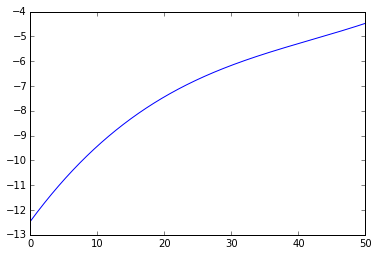

In [28]:
Vf = v['Vf'][0]
plot(linspace(0,50,1000),Vf(linspace(0,50,1000),1))

In [29]:
%autopx

%autopx enabled


This can be especially useful if I want to debug a piece of parallel code.  Take the first part of `approximateValueFunction`.  I can now evaluate pieces of it and see what they're doing.

In [30]:
#first split up domain for each process
s = comm.Get_size()
rank = comm.Get_rank()
n = len(Para.domain)
m = n//s
r = n%s

In [31]:
print("rank",rank,":", (rank*m+min(rank,r),(rank+1)*m+min(rank+1,r)))
%autopx

%autopx disabled


I now can see the rows of `Para.domain` assigned to each process.

### Caveats

One important thing to keep in mind is that the engines have their own local namespace.  You need to make sure that the appropriate libraries are imported in the engines and that they work in the right directory. Finally, while the code is being run, the engines can't print output.  All printed output is delayed until the command is done.  

## Multiple Hosts

Thus far, everything we have done has assumed that all of the processes will be run on the same machine.  Fortunately, to run the code one multiple machines requires only a modification to the mpiexec command.  The precise nature differs across versions of mpi.  We will be describing the procedure for `mpich`.  The steps for `openmpi` will be similar.  Suppose we had 4 machines with ipaddresses given by host1,host2,host3, and host4, and each of these machines had 4 processors on them.  If we want to run python code parallely across these machines we would create a file `hostfile` with the following lines

`
host1 : 4
host2 : 4
host3 : 4
host4 : 4
`

To execute the python code in Main.py we run the command

`
mpiexec -f hostfile python Main.py
`

## Appendix: .py files used 

In [32]:
%%writefile mpi_helloworld.py

from mpi4py import MPI

comm = MPI.COMM_WORLD #retreive the communicator module
rank = comm.Get_rank() #get the rank of the process
size = comm.Get_size() #get the number of processes

print("Hello world from process "+str(rank)+" of " + str(size))


Overwriting mpi_helloworld.py


In [41]:
%%writefile ./mpi/MPI_montecarlo.py

import numpy as np
from mpi4py import MPI

N = 10000

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

x = np.random.randn(N)
my_result = np.cos(x).mean() #my average

#now average accross all processes
results = comm.gather(my_result)
if rank == 0:
    print(np.mean(results))


Overwriting ./mpi/MPI_montecarlo.py


In [42]:
%%writefile ./mpi/MPI_montecarlo_allgather.py

import numpy as np
from mpi4py import MPI

N = 10000

comm = MPI.COMM_WORLD
rank = comm.Get_rank()

x = np.random.randn(N)
my_result = np.cos(x).mean() #my average

#now gather from all processes
results = comm.gather(my_result)

print("Gather result for process " + str(rank) +":",results)

#now allgather from all processes
results = comm.allgather(my_result)

print("Allgather resuts for process " + str(rank) + ":",results)


Overwriting ./mpi/MPI_montecarlo_allgather.py


In [43]:
%%writefile ./mpi/MPI_Allgather.py

import numpy as np
from mpi4py import MPI

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# create a 2x2 array filled with the rank of the process
x = np.ones((2,2)) * rank 

# create an empty array to store the gathered result
X = np.empty((2*size,2))

#use numpy Allgather
                #send buffer   #recv buffer
comm.Allgather([x, MPI.DOUBLE],[X, MPI.DOUBLE])

if rank ==0:
    print(X)


Overwriting ./mpi/MPI_Allgather.py


In [44]:
%%writefile ./mpi/primitives.py

"""
Created on Tue Jun 25 13:29:54 2013

@author: dgevans
"""
from numpy import *

class primitives(object):
    '''
    Class that holds the basic parameters of the problem
    '''
    
    beta = 0.95#discount factor
    
    rho = 0.9#persistence of idiosyncratic productivity
    
    sigma_e = 0.1#standard deviation of idiosyncratic productivity
    
    a_min = 0.0 #minimum assets
    
    a_max = 60.0 #maximum assets
    
    z_min = -2. #minimum productivity
    
    z_max = 2. #maximum productivity
    
    
    
class primitives_CRRA(primitives):
    '''
    Extension of primitives class holding the preference structure
    '''
    
    sigma = 2.
    
    def U(self,c):
        """
        CRRA utility function
        """
        sigma = self.sigma
        if sigma == 1.:
            return log(c)
        else:
            return (c)**(1-sigma)/(1-sigma)
            
    def Uc(self,c):
        """
        Derivative of the CRRA utility function
        """
        sigma = self.sigma
        return c**(-sigma)
        
        

Writing ./mpi/primitives.py


In [45]:
%%writefile ./mpi/bellman.py

"""
Created on Tue Jun 25 13:40:30 2013
Holds all of the code for the bellman equation
@author: dgevans
"""

from scipy.optimize import minimize_scalar

from numpy import * 
from mpi4py import MPI
from scipy.interpolate import SmoothBivariateSpline
from numpy.polynomial.hermite import hermgauss

#compute nodes for gaussian quadrature.
zhatvec,z_weights = hermgauss(10)
z_weights /= sum(z_weights)


def approximateValueFunction(TV,Para):
    '''
    Approximates the value function over the grid defined by Para.domain.  Uses
    mpi. Returns both an interpolated value function and the value of TV at each point
    in the domain.
    '''
    comm = MPI.COMM_WORLD
    #first split up domain for each process
    s = comm.Get_size()
    rank = comm.Get_rank()
    n = len(Para.domain)
    m = n//s
    r = n%s
    #let each process take a slice of the domain
    mydomain = Para.domain[rank*m+min(rank,r):
                           (rank+1)*m+min(rank+1,r)]

    #get the value at each point in my domain
    myV = hstack(map(TV,mydomain))
    #gather the values for each process
    Vs = comm.gather(myV)
    
    if rank == 0:
        #fit 
        Vs = hstack(Vs).flatten()
        Vf = SmoothBivariateSpline(Para.domain[:,0],Para.domain[:,1],Vs)
    else:
        Vf = None
    return comm.bcast(Vf),comm.bcast(Vs)
    
    
    
    

class BellmanMap(object):
    '''
    Bellman map object.  Once constructed will take a value function and return
    a new value function
    '''
    
    def __init__(self,Para,r):
        '''
        Initializes the Bellman Map function.  Need parameters and r
        '''
        self.Para = Para
        self.r = r
        self.w = 1.
        
    def __call__(self,Vf):
        '''
        Given a current value function return new value function
        '''
        self.Vf = Vf
        
        return lambda x: self.maximizeObjective(x[0],x[1])[0]
        
        
    def maximizeObjective(self,a,z):
        '''
        Maximize the objective function Vf given the states a and productivity z.
        Note the state for this problem are assets and previous periods productivity
        return tuple (V,c_policy,a_policy)
        '''
        
        #total wealth for agent is easy
        W = (1+self.r)*a + exp(z)*self.w
        beta = self.Para.beta
        Vf = self.Vf
        
        
        def obj_f(aprime):
            c = W-aprime
            return -(self.Para.U(c) + beta*self.E(lambda zprime:Vf(aprime,zprime).flatten(),z))
        
        a_min = self.Para.a_min
        a_max = min(self.Para.a_max,W-0.00001)
        
        res = minimize_scalar(obj_f,bounds=(a_min,a_max),method='bounded')
        
        return -res.fun,W-res.x,res.x
         
    def E(self,f,z_):
        '''
        Compute the exepected value of a function f of zprime conditional on z
        '''
        #Pz_min,Pz_max,z_pdf = self.get_z_distribution(z_)
        z_min = array([self.Para.z_min])
        z_max = array([self.Para.z_max])
        #Compute the nodes for Gaussian quadrature
        zvec = self.Para.rho * z_ + self.Para.sigma_e*zhatvec*sqrt(2)
        
        #lower bound for z
        zvec[zvec<z_min] = z_min 
        #upper bound for z
        zvec[zvec>z_max] = z_max
        return z_weights.dot(f(zvec))

Writing ./mpi/bellman.py


In [46]:
%%writefile ./mpi/Main.py

"""
Created on Tue Jun 25 16:50:32 2013

@author: dgevans
"""

from numpy import *
from primitives import primitives_CRRA
import bellman
from mpi4py import MPI

rank = MPI.COMM_WORLD.Get_rank()

#initialize the parameters
Para = primitives_CRRA()
r = 0.9995*(1/Para.beta-1)

#create the grid
agrid = hstack((linspace(Para.a_min,Para.a_min+1.,15),linspace(Para.a_min+2.,Para.a_max,15)))
zgrid = linspace(Para.z_min,Para.z_max,10)
Para.domain = vstack([(a,z) for a in agrid for z in zgrid])

#initial value function
def V0(a,z):
    return Para.U(exp(z)+r*a)/(1-Para.beta)

#construct the Bellman Map
T = bellman.BellmanMap(Para,r)

#iterate on the Bellman Map until convergence
Vf,Vs = bellman.approximateValueFunction(T(V0),Para)
while diff > 1e-6:  
    Vfnew,Vsnew = bellman.approximateValueFunction(T(Vf),Para)
    diff =  max(abs(Vs-Vsnew))
    if rank == 0:
        print diff
    Vf = Vfnew
    Vs = Vsnew


Writing ./mpi/Main.py
